# Binarization

## 0. Import package

In [2]:
%matplotlib notebook

import cv2
import collections

import openalea.phenomenal.image as phm_img
import openalea.phenomenal.data as phm_data
import openalea.phenomenal.display as phm_display

import pandas

## 1. Prerequisites

### 1. Load images

Here, we load all the image of the dataset to simply the toturial, commodly you load just the images you want process one after the other.

In [11]:
fname = '/home/ubuntu/unn.csv.gz'
index =  pandas.read_csv(fname, sep=';')
# raw image
row = index.loc[1]


def raw_images(row):
    d = dict(side={}, top={})
    images = eval(row.path)
    angles = eval(row.camera_angle)
    views = eval(row.view_type)
    
    for img, ang, view in zip(images, angles, views):
        d['side' if view == 'SV' else 'top'][ang]= cv2.imread(img, cv2.IMREAD_UNCHANGED)
    return d
dd=raw_images(row)
raw_images = dd
#raw_images = phm_data.raw_images(plant_number=6)

In [14]:
raw_images['side'].keys()

[288, 0, 36, 72, 108, 144, 180, 216, 324, 252]

### 1.3. Display images 

You can view each image according to this date and angle of view like this :
Note : Angle top view is represented by negative number (-1)

<IPython.core.display.Javascript object>


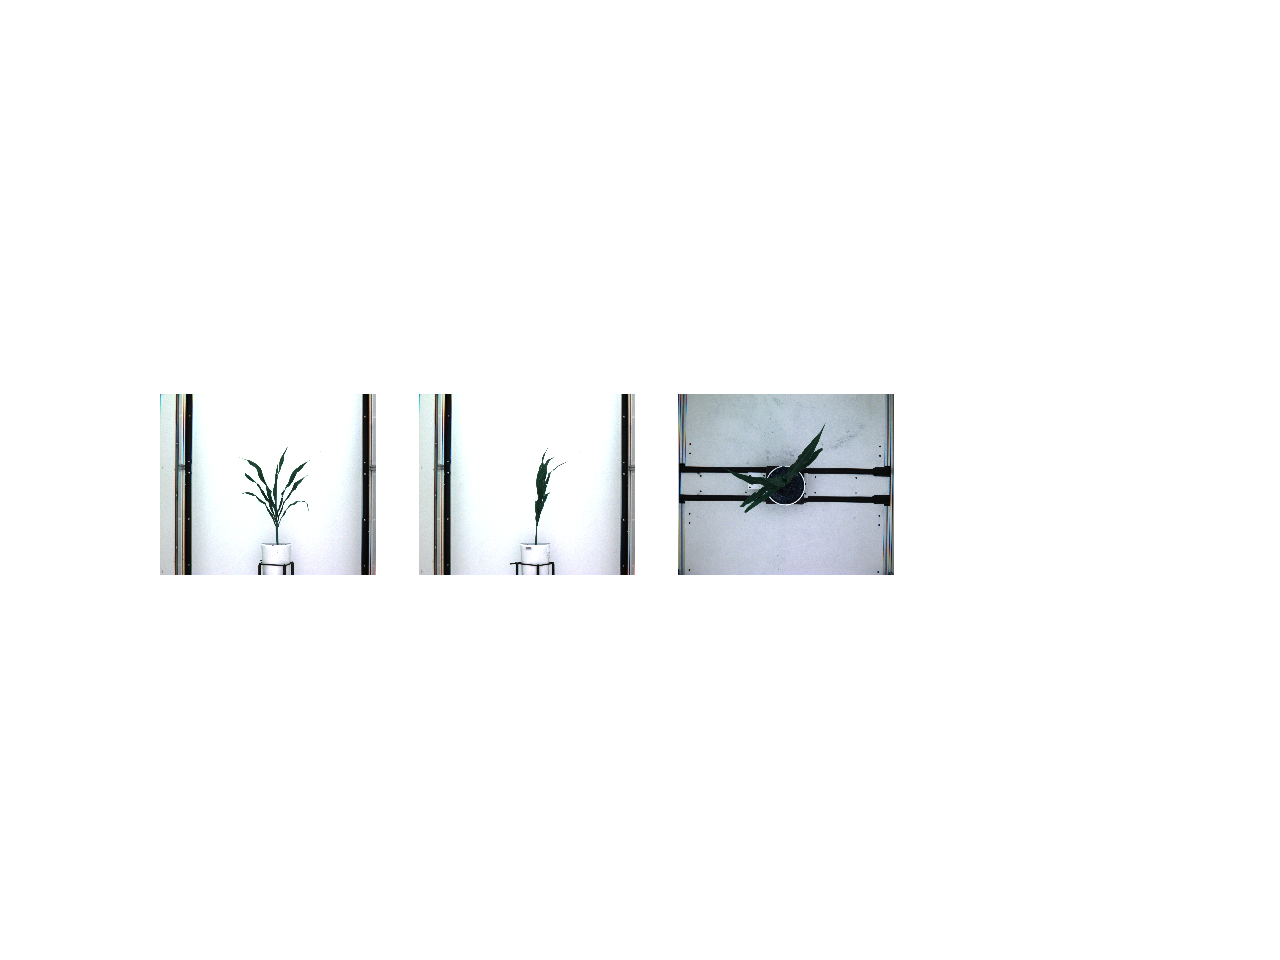

In [15]:
phm_display.show_images([raw_images['side'][108], 
                         raw_images['side'][36], 
                         raw_images['top'][90]])

## 2. Binarization

### 2.1. Define a binarization routines

In [4]:
def routine_side_binarization(image, mean_img):

    maks = phm_data.tutorial_data_binarization_mask()
    
    threshold = 0.3
    dark_background = False

    hsv_min = (30, 11, 0)
    hsv_max = (129, 254, 141)
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Threshold the image with HSV min and max value
    binary_hsv_image = phm_img.threshold_hsv(hsv_image, hsv_min, hsv_max, maks[0])
    
    # Threshold the image with difference between image and mean_image
    binary_mean_shift_image = phm_img.threshold_meanshift(
        image, mean_img, threshold, dark_background, maks[1])
    
    # Add the two image
    result = cv2.add(binary_hsv_image, binary_mean_shift_image)

    # Erode and dilate the image to remove possible noise
    result = cv2.medianBlur(result, 3)
    
    return result


def routine_top_binarization(image):
    hsv_min = (42, 75, 28)
    hsv_max = (80, 250, 134)
    median_blur_size=9
    iterations=5
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Apply a median blur on the image
    hsv_image = cv2.medianBlur(hsv_image, ksize=median_blur_size)

    # Threshold the image with HSV min and max value
    bin_img = phm_img.threshold_hsv(hsv_image, hsv_min, hsv_max)
    # dilate and erode the image to remove possible noise
    bin_img = phm_img.dilate_erode(bin_img, kernel_shape=(3, 3),iterations=iterations)

    return bin_img

### 2.2. Binarize images

In [5]:
# Compute the mean image of the side view image
mean_img = phm_img.mean_image(raw_images['side'].values())

routine_binarization = {
    'side': lambda im : routine_side_binarization(im, mean_img),
    'top': lambda im : routine_top_binarization(im)}

bin_images = collections.defaultdict(dict)
for id_camera in raw_images:
    for angle in raw_images[id_camera]:
        bin_images[id_camera][angle] = routine_binarization[id_camera](raw_images[id_camera][angle])
             

### 2.3. Display images binarize 

<IPython.core.display.Javascript object>


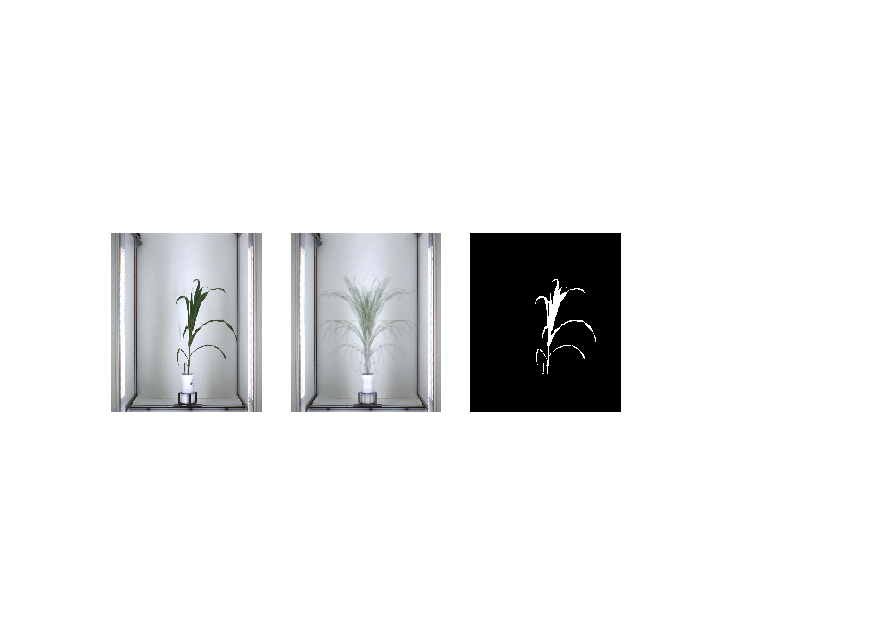

In [10]:
id_camera, angle = 'side', 120
phm_display.show_images([raw_images[id_camera][angle], mean_img, bin_images[id_camera][angle]])

<IPython.core.display.Javascript object>


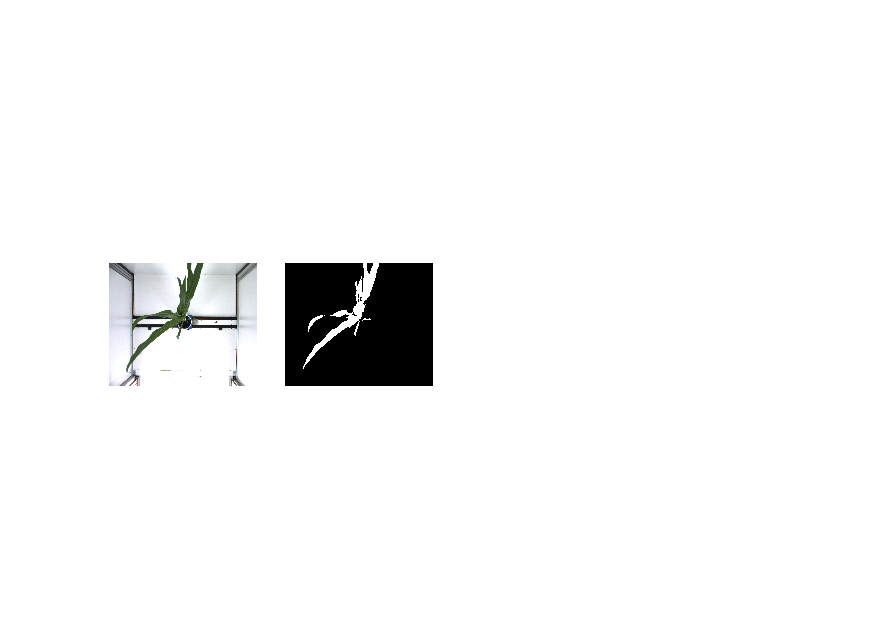

In [11]:
id_camera, angle = 'top', 0
phm_display.show_images([raw_images[id_camera][angle], bin_images[id_camera][angle]])